**Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. 

Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

Есть несколоко задач. **Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.**

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.**


Задача 1: предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:

id — уникальный идентификатор сотрудника;
dept — отдел, в котором работает сотрудник;
level — уровень занимаемой должности;
workload — уровень загруженности сотрудника;
employment_years — длительность работы в компании (в годах);
last_year_promo — показывает, было ли повышение за последний год;
last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
salary — ежемесячная зарплата сотрудника;
job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Задача 2: предсказание увольнения сотрудника из компании

Для этой задачи используем те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

In [1]:
!pip install pip -U
!pip install phik -U
!pip install -U scikit-learn
!pip install seaborn -U

In [2]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
plt.rcParams["figure.figsize"] = (15, 10)
import seaborn as sns
from typing import List
import warnings
from sklearn.datasets import make_classification
import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

In [3]:
RANDOM_STATE = 42

**Шаг 1. Загрузка данных**

In [4]:
try:
    df_test_features = pd.read_csv('project/test_features.csv')
except Exception:
    df_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')

try:
    df_test_target_job_satisfaction_rate = pd.read_csv('project/test_target_job_satisfaction_rate.csv')
except Exception:
    df_test_target_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

try:
    df_test_target_quit = pd.read_csv('project/test_target_quit.csv')
except Exception:
    df_test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

try:
    df_train_job_satisfaction_rate = pd.read_csv('project/train_job_satisfaction_rate.csv')
except Exception:
    df_train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

try:
    df_train_quit = pd.read_csv('project/train_quit.csv')
except Exception:
    df_train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')

Информация по датафрейму *train_job_satisfaction_rate*:

In [5]:
df_train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [6]:
df_train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Имеются столбцы:

- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [7]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [8]:
df_train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Размерности всех датафреймов:

In [9]:
df_train_job_satisfaction_rate.shape, df_train_quit.shape, df_test_features.shape, df_test_target_quit.shape, df_test_target_job_satisfaction_rate.shape

((4000, 10), (4000, 10), (2000, 9), (2000, 2), (2000, 2))

In [10]:
df_train_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [11]:
df_train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [12]:
df_test_features.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [13]:
df_test_target_job_satisfaction_rate.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


In [14]:
df_test_target_quit.describe()

,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


**Выбросы в датафреймах не выявлены**

Новый признак **quit** - увольнение сотрудника из компании.

Работа с пропусками:

In [15]:
df_train_job_satisfaction_rate.isna().sum().sort_values()

id                       0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
level                    4
dept                     6
dtype: int64

Пропуски имеются в колонках: level и dept. 4 и 6 пропусков соответственно.

In [16]:
df_train_quit.isna().sum().sort_values()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Нет пропусков

Работа с признаками:

In [17]:
df_train_job_satisfaction_rate['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [18]:
df_train_job_satisfaction_rate['dept'].value_counts(normalize=True)

sales         0.378568
technology    0.216825
purchasing    0.152729
marketing     0.137707
hr            0.114171
Name: dept, dtype: float64

In [19]:
df_train_job_satisfaction_rate['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [20]:
df_train_job_satisfaction_rate['level'].value_counts(normalize=True)

junior    0.473974
middle    0.436436
sinior    0.089590
Name: level, dtype: float64

In [21]:
df_train_job_satisfaction_rate['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [22]:
df_train_job_satisfaction_rate['workload'].value_counts(normalize=True)

medium    0.5165
low       0.3000
high      0.1835
Name: workload, dtype: float64

In [23]:
df_train_job_satisfaction_rate['employment_years'].unique()

array([ 2,  1,  4,  7,  9,  6,  3, 10,  8,  5])

In [24]:
df_train_job_satisfaction_rate['employment_years'].value_counts()

1     966
2     785
3     483
4     384
5     380
7     301
6     287
8     193
9     130
10     91
Name: employment_years, dtype: int64

In [25]:
df_train_job_satisfaction_rate['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [26]:
df_train_job_satisfaction_rate['last_year_promo'].value_counts()

no     3880
yes     120
Name: last_year_promo, dtype: int64

In [27]:
df_train_job_satisfaction_rate['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [28]:
df_train_job_satisfaction_rate['last_year_violations'].value_counts()

no     3441
yes     559
Name: last_year_violations, dtype: int64

In [29]:
df_train_job_satisfaction_rate['supervisor_evaluation'].unique()

array([1, 5, 2, 3, 4])

In [30]:
df_train_job_satisfaction_rate['supervisor_evaluation'].value_counts()

4    1603
3    1263
5     546
2     387
1     201
Name: supervisor_evaluation, dtype: int64

In [31]:
df_train_job_satisfaction_rate['salary'].unique()

array([24000, 38400, 12000, 18000, 22800, 30000, 56400, 52800, 13200,
       54000, 19200, 40800, 34800, 27600, 26400, 33600, 50400, 15600,
       14400, 25200, 72000, 31200, 32400, 48000, 43200, 46800, 58800,
       84000, 44400, 39600, 37200, 21600, 28800, 62400, 60000, 42000,
       49200, 55200, 57600, 68400, 45600, 51600, 64800, 80400, 20400,
       61200, 76800, 69600, 16800, 36000, 63600, 81600, 66000, 74400,
       67200, 70800, 73200, 75600, 79200, 94800, 78000, 88800, 92400,
       85200, 91200, 98400, 96000, 97200])

In [32]:
df_train_job_satisfaction_rate['salary'].value_counts(bins=10)

(20640.0, 29280.0]      1174
(11913.599, 20640.0]     736
(29280.0, 37920.0]       697
(37920.0, 46560.0]       604
(46560.0, 55200.0]       406
(55200.0, 63840.0]       224
(63840.0, 72480.0]        93
(72480.0, 81120.0]        44
(81120.0, 89760.0]        13
(89760.0, 98400.0]         9
Name: salary, dtype: int64

In [33]:
df_train_job_satisfaction_rate['job_satisfaction_rate'].unique()

array([0.58, 0.76, 0.11, 0.37, 0.2 , 0.78, 0.56, 0.44, 0.14, 0.47, 0.74,
       0.42, 0.32, 0.57, 0.16, 0.69, 0.33, 0.64, 0.39, 0.8 , 0.79, 0.17,
       0.65, 0.18, 0.19, 0.49, 0.63, 0.22, 0.23, 0.5 , 0.35, 0.3 , 0.77,
       0.88, 0.59, 0.21, 0.36, 0.85, 0.7 , 0.48, 0.6 , 0.1 , 0.27, 0.71,
       0.86, 0.54, 0.73, 0.46, 0.31, 0.72, 0.51, 0.61, 0.81, 0.99, 0.15,
       0.91, 0.68, 0.4 , 0.89, 0.67, 0.75, 0.98, 0.26, 0.45, 0.92, 0.82,
       0.66, 0.55, 0.38, 0.53, 0.84, 0.52, 0.24, 0.62, 0.41, 0.28, 0.09,
       0.97, 0.83, 0.25, 0.43, 0.04, 0.13, 0.29, 0.95, 0.93, 0.87, 0.08,
       0.94, 0.07, 0.34, 0.9 , 0.12, 0.06, 0.96, 0.05, 1.  , 0.03])

In [34]:
df_train_job_satisfaction_rate['job_satisfaction_rate'].value_counts(bins=10)

(0.612, 0.709]    683
(0.709, 0.806]    565
(0.321, 0.418]    523
(0.515, 0.612]    491
(0.418, 0.515]    437
(0.224, 0.321]    374
(0.806, 0.903]    373
(0.127, 0.224]    336
(0.028, 0.127]    123
(0.903, 1.0]       95
Name: job_satisfaction_rate, dtype: int64

В датафрейме пропусков не выявлено

Промежуточный вывод: 
- в датафрейме пропуски выявлены в столбцах level и dept
- рассмотрено количество значений каждого признака
- рассмотрены уникальные значения признаков

Методом describe() была выведена описательная статистика каждого датафрейма
- выбросов не выявлено

In [35]:
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [36]:
df_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [37]:
df_test_features.isna().sum().sort_values()

id                       0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
level                    1
dept                     2
dtype: int64

In [38]:
df_test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [39]:
df_test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [40]:
df_test_target_job_satisfaction_rate.isna().sum().sort_values()

id                       0
job_satisfaction_rate    0
dtype: int64

In [41]:
df_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [42]:
df_test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [43]:
df_test_target_quit.isna().sum().sort_values()

id      0
quit    0
dtype: int64

**Шаг 3. Исследовательский анализ данных**

Описательная статистика тренировочных датафреймов:

In [44]:
df_train_job_satisfaction_rate.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


По средним значениям входных признаков:
- employment_years - 3.7
- supervisor_evaluation - 3.4
- salary - 33926.7

Среднее целевого признака:
- job_satisfaction_rate - 0.53

In [45]:
df_train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [46]:
df_test_features = df_test_features.replace(' ', np.nan)

Функция для построения гистограмм:

In [47]:
def function_for_histograms(data, column, bins=25):
    sns.set()
    sns.histplot(data=data, x=column, bins=bins)
    plt.title(f'{column} Распределение', fontsize=20)
    plt.xlabel(column, fontsize=15)
    plt.ylabel('Частота', fontsize=15)
    plt.show()

Функция для барплотов:

In [48]:
def function_for_barplots(data, column):
    data_for_barplot = data[column].value_counts()
    df_data = data_for_barplot.reset_index()
    df_data.columns = [column, 'count']
    sns.barplot(x=column, y='count', data = df_data)
    plt.title(f'{column} Распределение')
    plt.xlabel(column)
    plt.ylabel('Частота')

Создание функции для списков с количественными и категориальными значениями:

In [49]:
def function_for_categorical_number(df):
    number_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    #убрать айди
    number_names.remove('id')
    
    categorial_names = list(df.select_dtypes(include=['object']).columns)

    return number_names, categorial_names

In [50]:
df_number_names, df_categorial_names = function_for_categorical_number(df_train_job_satisfaction_rate)

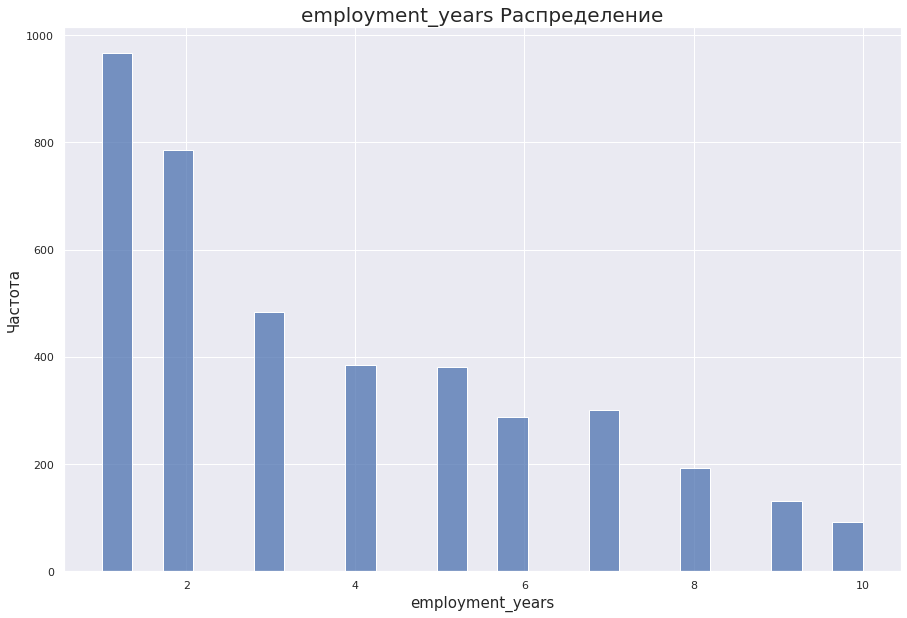

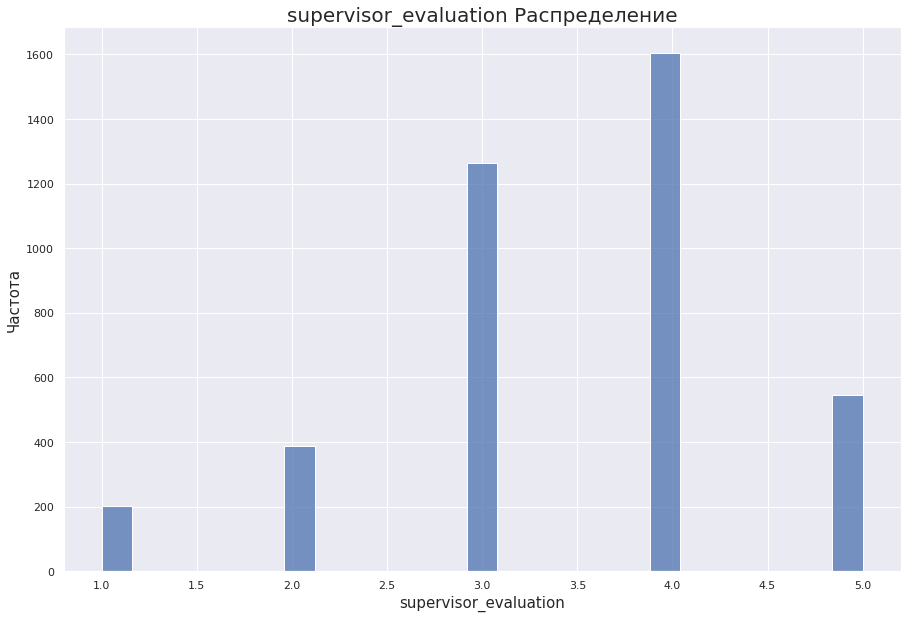

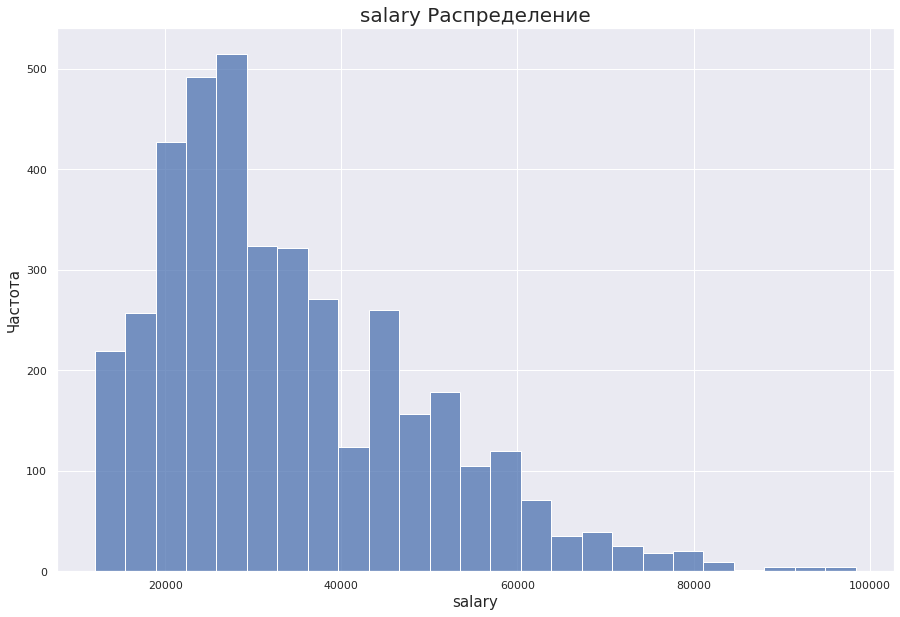

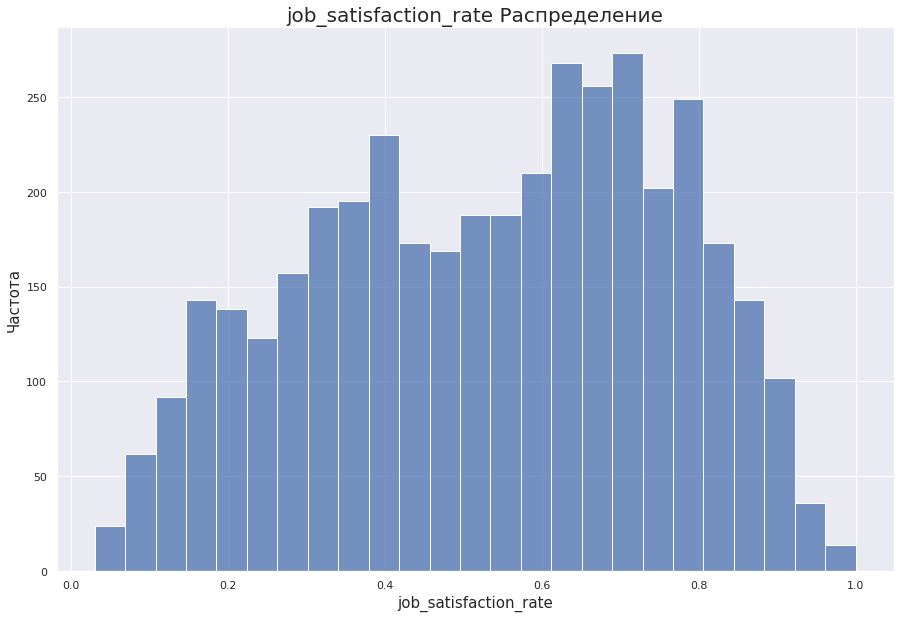

In [51]:
for feature in df_number_names:
    function_for_histograms(df_train_job_satisfaction_rate, feature)

По графикам:
- частота значения уменьшается по мере увеличения employment_years (работающих 1-3 года большего всего)
- **4** - самая распространненая оценка качества работы сотрудника, которую дал руководитель
- большего всего людей с зп около 30к
- уровень удовлетворённости сотрудника работой в компании имеет нормальное распределение

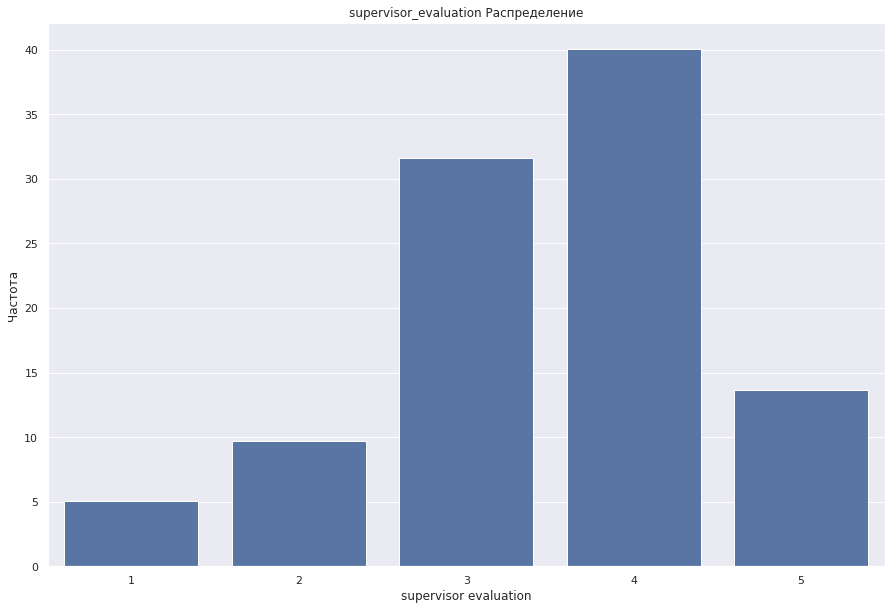

In [52]:
sns.countplot(df_train_job_satisfaction_rate, x="supervisor_evaluation", stat="percent")
plt.title('supervisor_evaluation Распределение')
plt.xlabel('supervisor evaluation')
plt.ylabel('Частота')
plt.show()

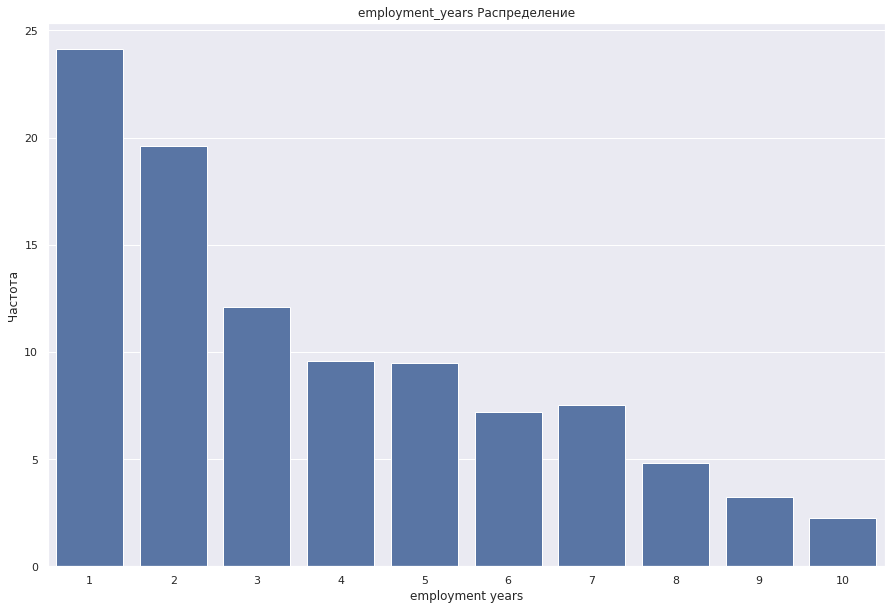

In [53]:
sns.countplot(df_train_job_satisfaction_rate, x="employment_years", stat="percent")
plt.title('employment_years Распределение')
plt.xlabel('employment years')
plt.ylabel('Частота')

plt.show()

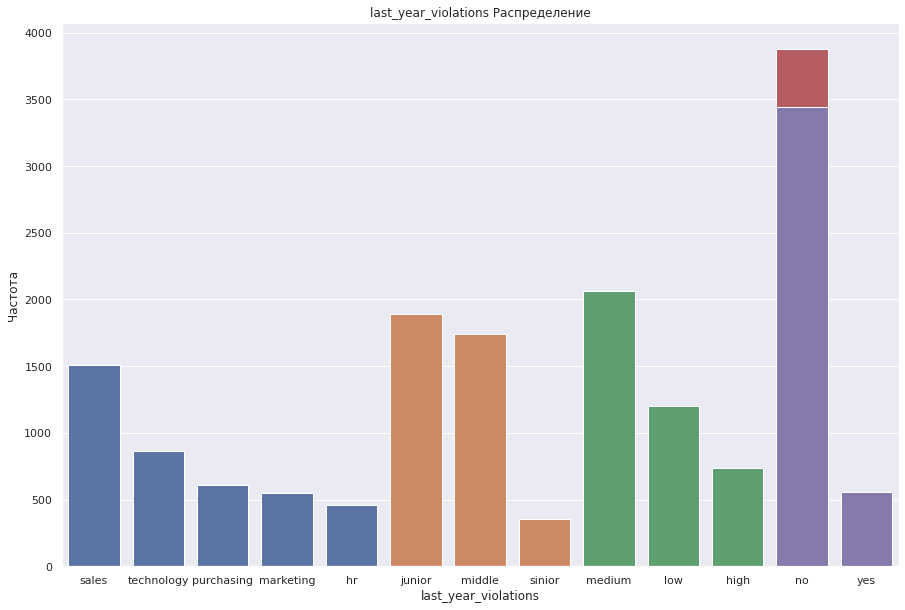

In [54]:
for feature in df_categorial_names:
    function_for_barplots(df_train_job_satisfaction_rate, feature)

По графикам:
- частота значения уменьшается по мере увеличения employment_years (работающих 1-3 года большего всего)
- **4** - самая распространненая оценка качества работы сотрудника, которую дал руководитель
- большего всего людей с зп около 30к
- уровень удовлетворённости сотрудника работой в компании имеет нормальное распределение

In [55]:
# Матрица корреляции и тепловая карта

def plot_correlation_heatmap(data):

    num_col_names = list(data.select_dtypes(include=['int64', 'float64']).columns)

    plt.figure(figsize=(15, 10))
    sns.heatmap(data[num_col_names].corr(method="spearman"), annot=True, linewidth=0.2)

    plt.title("Correlation Heatmap")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.show()

In [56]:
interval_cols = ['salary', 'job_satisfaction_rate']

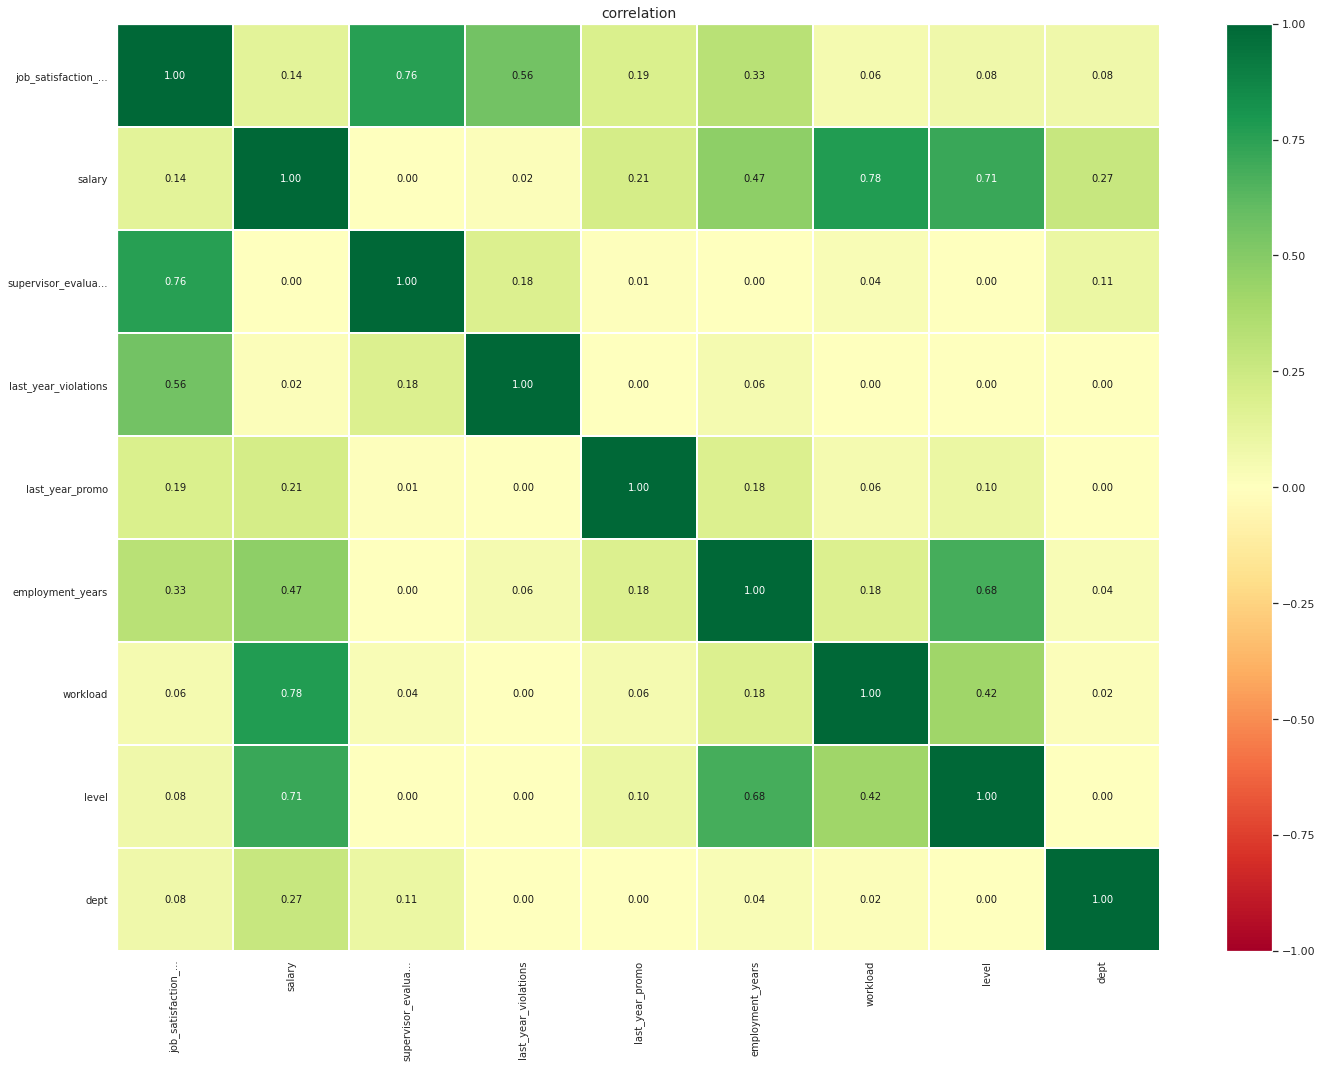

In [57]:
phik_overview = df_train_job_satisfaction_rate.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        figsize=(20, 15))

C целевым признаком - **job_satisfaction_rate**

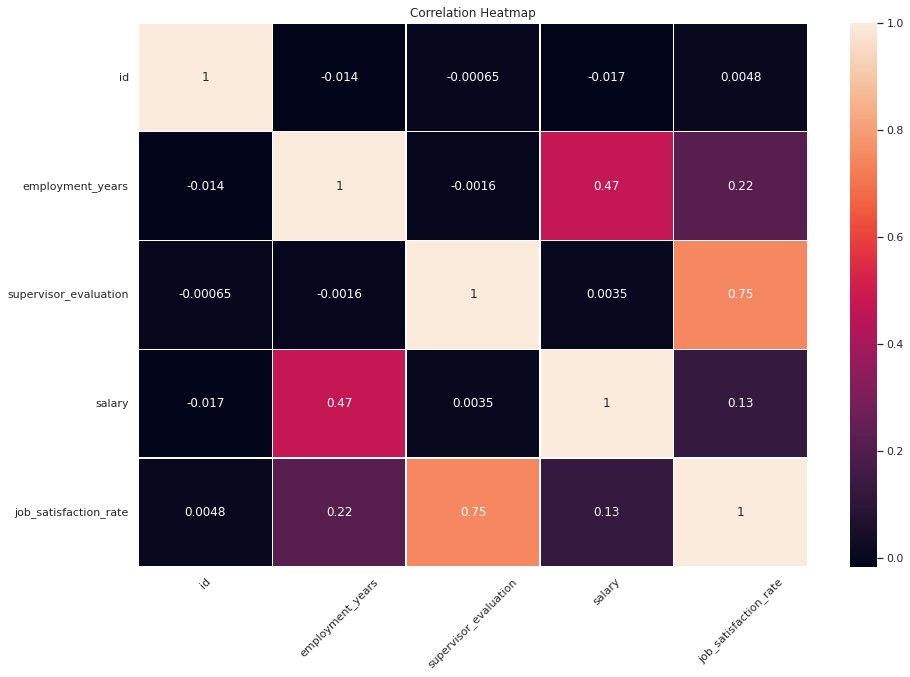

In [58]:
plot_correlation_heatmap(df_train_job_satisfaction_rate)

Изучение целевого признака тестовой выборки:

In [59]:
df_test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [60]:
df_test_target_job_satisfaction_rate.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


**Шаг 4. Подготовка данных**

Выделение входных и целевого признака:

In [61]:
df_train_job_satisfaction_rate = df_train_job_satisfaction_rate.drop(['id'], axis=1)

In [62]:
df_train_job_satisfaction_rate.duplicated().sum()

245

In [63]:
df_train_job_satisfaction_rate = df_train_job_satisfaction_rate.drop_duplicates()

In [64]:
df_train_job_satisfaction_rate.duplicated().sum()

0

Мердж по id

In [65]:
X_regression_train = df_train_job_satisfaction_rate.drop('job_satisfaction_rate', axis=1)
y_regression_train = df_train_job_satisfaction_rate['job_satisfaction_rate']

In [66]:
X_test = df_test_features.drop(['id'], axis=1)
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,marketing,junior,medium,2,no,no,5,28800
1,hr,junior,medium,1,no,no,4,30000
2,sales,middle,low,5,no,no,4,19200
3,sales,middle,low,6,no,no,4,19200
4,hr,middle,medium,5,no,no,5,40800


In [67]:
df_test_target_job_satisfaction_rate = df_test_target_job_satisfaction_rate.merge(df_test_features['id'], how='right', on='id')
df_test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,485046,0.79
1,686555,0.72
2,467458,0.64
3,418655,0.60
4,789145,0.75


In [68]:
y_test = df_test_target_job_satisfaction_rate['job_satisfaction_rate']
y_test.head()

0    0.79
1    0.72
2    0.64
3    0.60
4    0.75
Name: job_satisfaction_rate, dtype: float64

In [69]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

In [70]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
) 

'''
При порядковом кодировании необходимо задать порядок категоризации. 
Поэтому в параметре categories последовательно перечислим 
уровни категорий для каждого признака из списка ord_columns.
'''

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [71]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Кодирование с помощью пайплайнов

In [72]:
'''
Пайплайн data_preprocessor применяется к тренировочной и тестовой выборкам. 
1. Пайплайн data_preprocessor применяется к выборке X_train.
2. Затем обученный на тренировочных данных data_preprocessor применяется к выборке X_test.
3. Для обеих выборок создаём датафрейм с обозначением названия признаков после подготовки. 

Название признаков выводим с помощью команды get_feature_names_out() 
Эту и другие команды можно посмотреть в документации https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
'''

X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_regression_train),
    columns=data_preprocessor.get_feature_names_out())

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out())


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**SMAPE**

SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 

In [73]:
def SMAPE(y_true, predictions):
    smape = 100 * np.mean(np.abs(y_true - predictions) / ((np.abs(y_true) + np.abs(predictions)) / 2))
    return smape

# создаём пользовательскую метрику
scorer = make_scorer(SMAPE, greater_is_better=False) # greater_is_better — определяет, будет ли значение метрики расти или уменьшаться при повышении качества модели. 

In [74]:
model_linear_regression = LinearRegression()

smape_lr = cross_val_score(model_linear_regression, X_train_p, y_regression_train, scoring=scorer).mean() * -1
print('SMAPE LR:', smape_lr)

SMAPE LR: 24.986518255935266


In [75]:
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)

param_distributions = [
    {
        'max_depth': range(2, 17),
        'min_samples_split': range(2, 11),
        'min_samples_leaf': range(2, 11)
    }
]

rs = RandomizedSearchCV(
    model_dtr,
    param_distributions,
    n_jobs = -1,
    scoring = scorer,
    random_state=RANDOM_STATE,
    refit=True
)

rs.fit(X_train_p, y_regression_train)


print(f'SMAPE DTR: {-rs.best_score_}')
print('Модель и её параметры:\n\n', rs.best_estimator_)

SMAPE DTR: 15.750189214911353
Модель и её параметры:

 DecisionTreeRegressor(max_depth=15, min_samples_leaf=6, min_samples_split=8,
                      random_state=42)


SMAPE на тестовой выборке:

In [76]:
prediction_by_dtr = rs.predict(X_test_p)
SMAPE(y_test, prediction_by_dtr)

13.772659438077891

SMAPE = 13.772659438077891

**Иследованные модели: LinearRegression и DecisionTreeRegressor**

**Параметры лучшей модели:**

 DecisionTreeRegressor(max_depth=12, min_samples_leaf=6, min_samples_split=10,
                      random_state=42)

**smape на тестовой выборке лучшей модели = 14.002996521526615**

**Задача классификации**

Целевой признак **quit** — увольнение сотрудника из компании.

In [77]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [78]:
df_train_quit.isna().sum().sort_values()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Нет пропусков

In [79]:
df_train_quit['dept'].value_counts()

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

Cамый распространненный отдел - продажи
наименее распространенный - hr

In [80]:
df_train_quit['level'].value_counts()

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64

Больше всего джунов

In [81]:
df_train_quit['salary'].value_counts(bins=10)

(20400.0, 28800.0]      1176
(11915.999, 20400.0]     761
(28800.0, 37200.0]       727
(37200.0, 45600.0]       542
(45600.0, 54000.0]       354
(54000.0, 62400.0]       250
(62400.0, 70800.0]        93
(70800.0, 79200.0]        66
(79200.0, 87600.0]        22
(87600.0, 96000.0]         9
Name: salary, dtype: int64

Интервал зарплаты 20400.0 - 28800.0 самый распространенный

Пропусков нет

In [82]:
df_train_quit.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


**Выбросов нет**

Анализ целевого признака:

In [83]:
df_train_quit['quit'].value_counts()

no     2872
yes    1128
Name: quit, dtype: int64

In [84]:
df_number_names, df_categorial_names = function_for_categorical_number(df_train_quit)

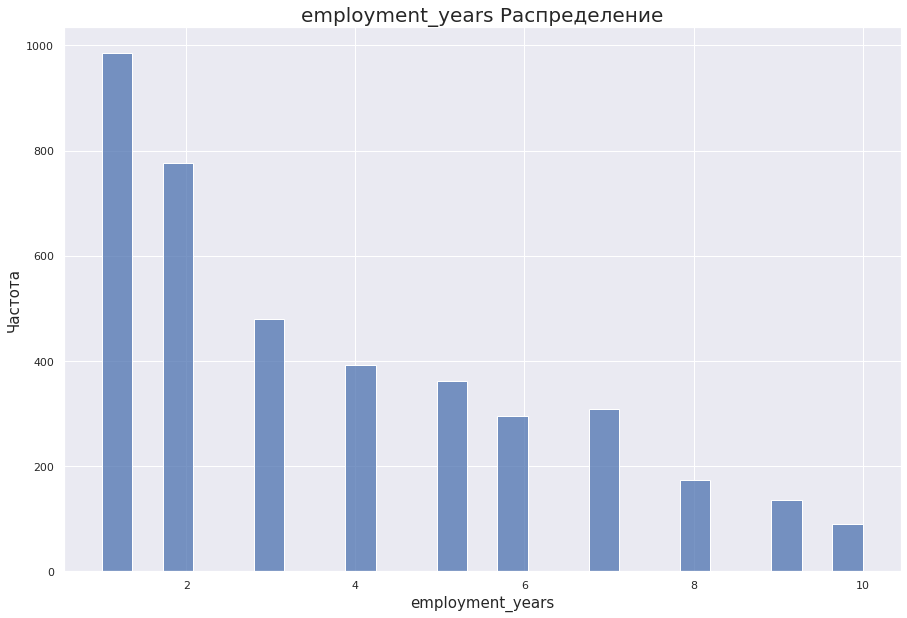

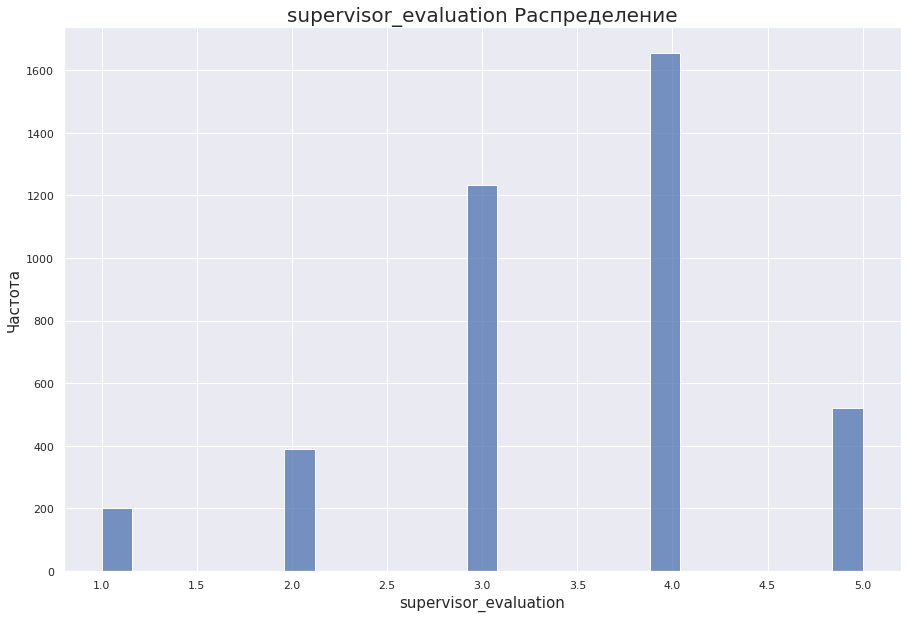

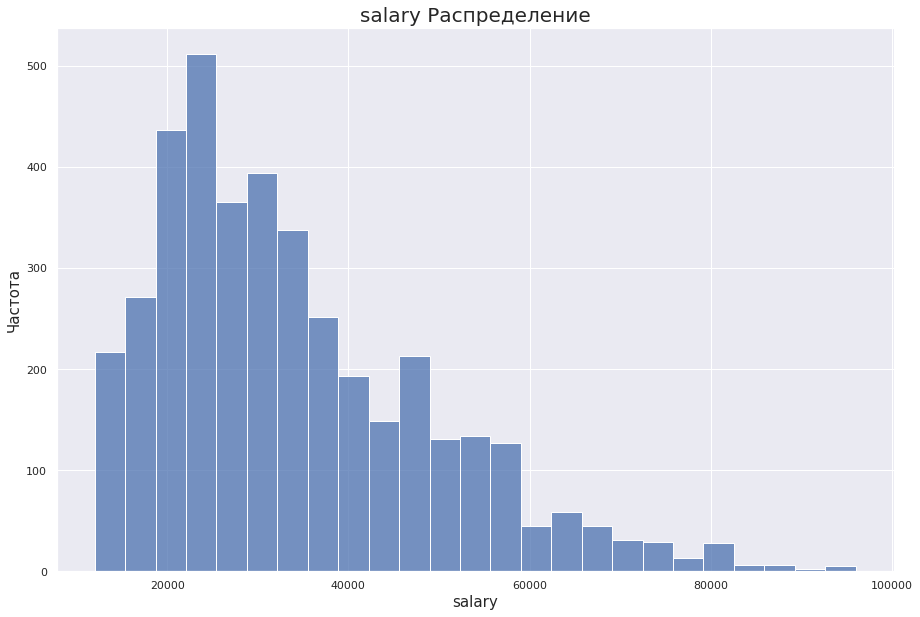

In [85]:
for feature in df_number_names:
    function_for_histograms(df_train_quit, feature)

Выводы по графикам:
- большее количество людей с зп в диапазоне от 20 до 35к
- самая распространенная оценка качества работы сотрудника - **4** следом **3**
- больше всего людей, работающих около года

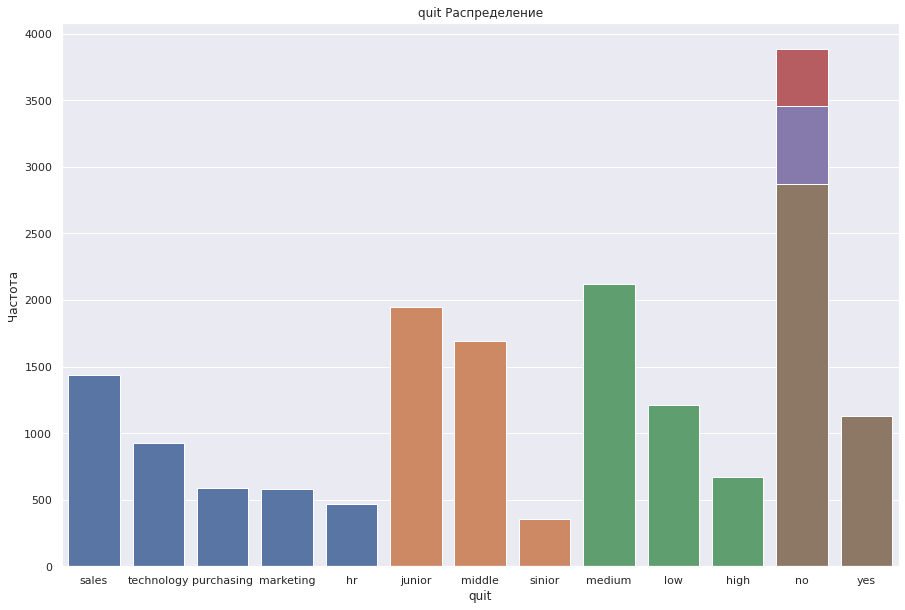

In [86]:
for feature in df_categorial_names:
    function_for_barplots(df_train_quit, feature)

Выводы по графикам:
- значение 'no' у целевого признака 'quit' почти в 3 раза чаще чем 'yes'
- около 500 нарушавших трудовой договор сотрудников
- больше всего людей, работающих около года
- повышений за год было крайне мало
- частота уровней нагрузки по убыванию: больше всего - медиум, далее - лоу и хай
- количество должностей: больше всего джунов, меньше всего синьеров, что логично
- из отдела продаж сотрудников больше всего

In [87]:
# Матрица корреляции и тепловая карта

def plot_correlation_heatmap(data):

    num_col_names = list(data.select_dtypes(include=['int64', 'float64']).columns)
    #correlation_matrix = data[num_col_names].corr()

    plt.figure(figsize=(15, 10))
    sns.heatmap(data[num_col_names].corr(method="spearman"), annot=True, linewidth=0.2)

    plt.title("Correlation Heatmap")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.show()

In [88]:
interval_cols = ['employment_years', 'salary']

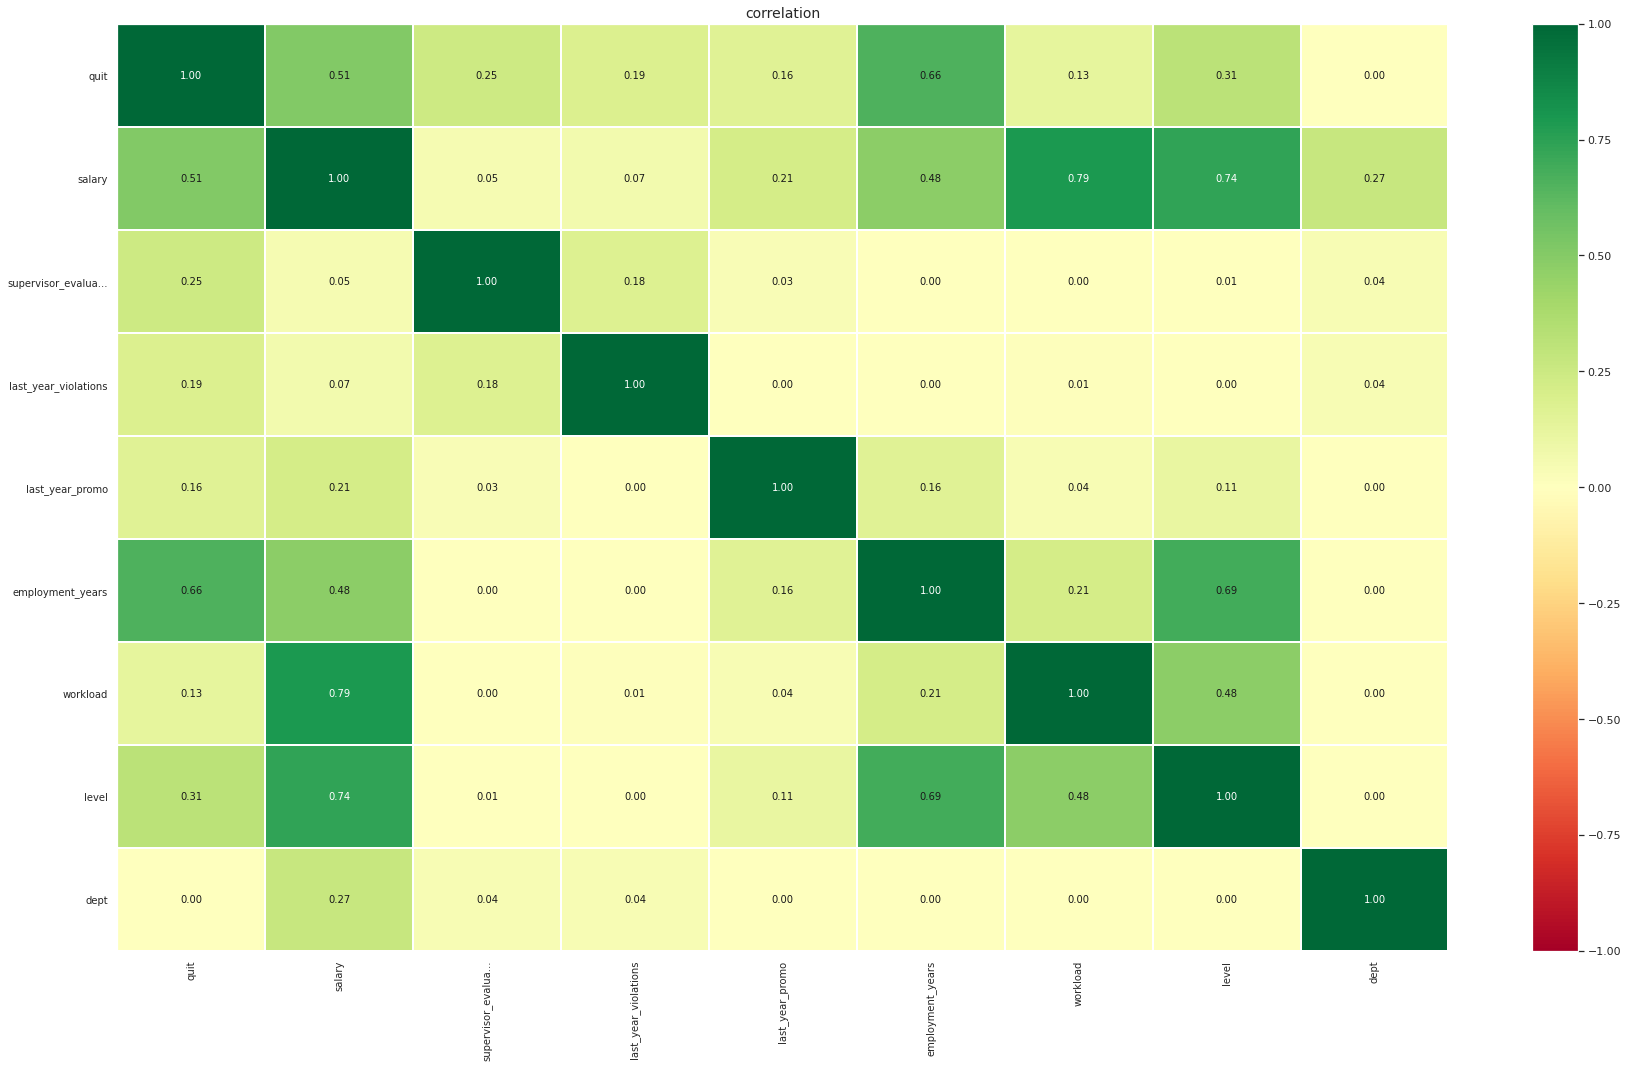

In [89]:
phik_overview = df_train_quit.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        figsize=(25, 15))

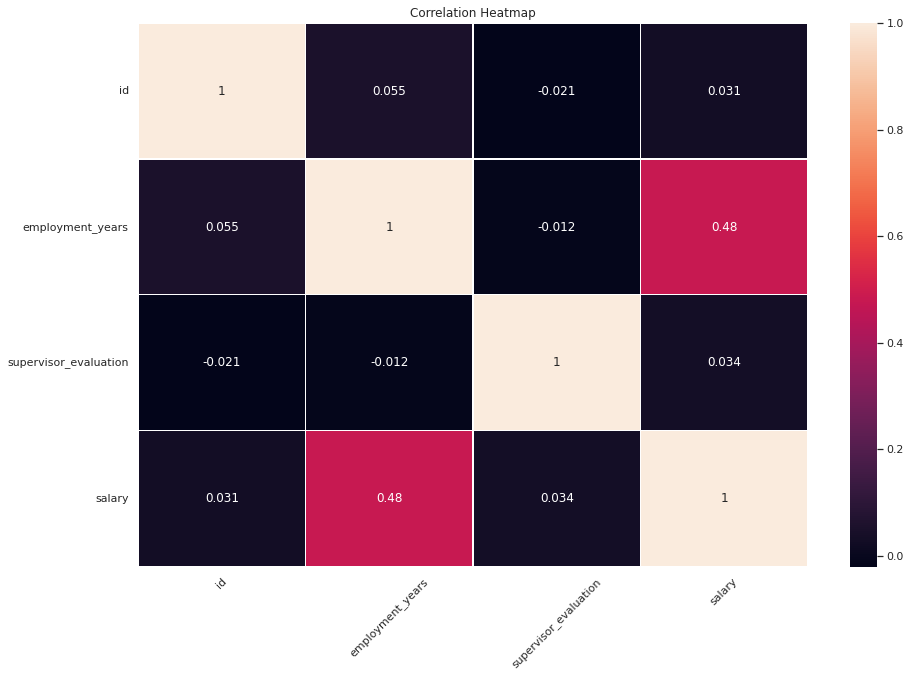

In [90]:
plot_correlation_heatmap(df_train_quit)

In [91]:
df_test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [92]:
df_test_target_quit['quit'].value_counts()

no     1436
yes     564
Name: quit, dtype: int64

**Шаг 4. Добавление нового входного признака**

Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [93]:
target_features = df_test_target_job_satisfaction_rate.merge(df_test_target_quit, on='id')

In [94]:
target_features.head()

,id,job_satisfaction_rate,quit
0,485046,0.79,no
1,686555,0.72,no
2,467458,0.64,no
3,418655,0.60,no
4,789145,0.75,no


In [95]:
interval_col = ['job_satisfaction_rate']

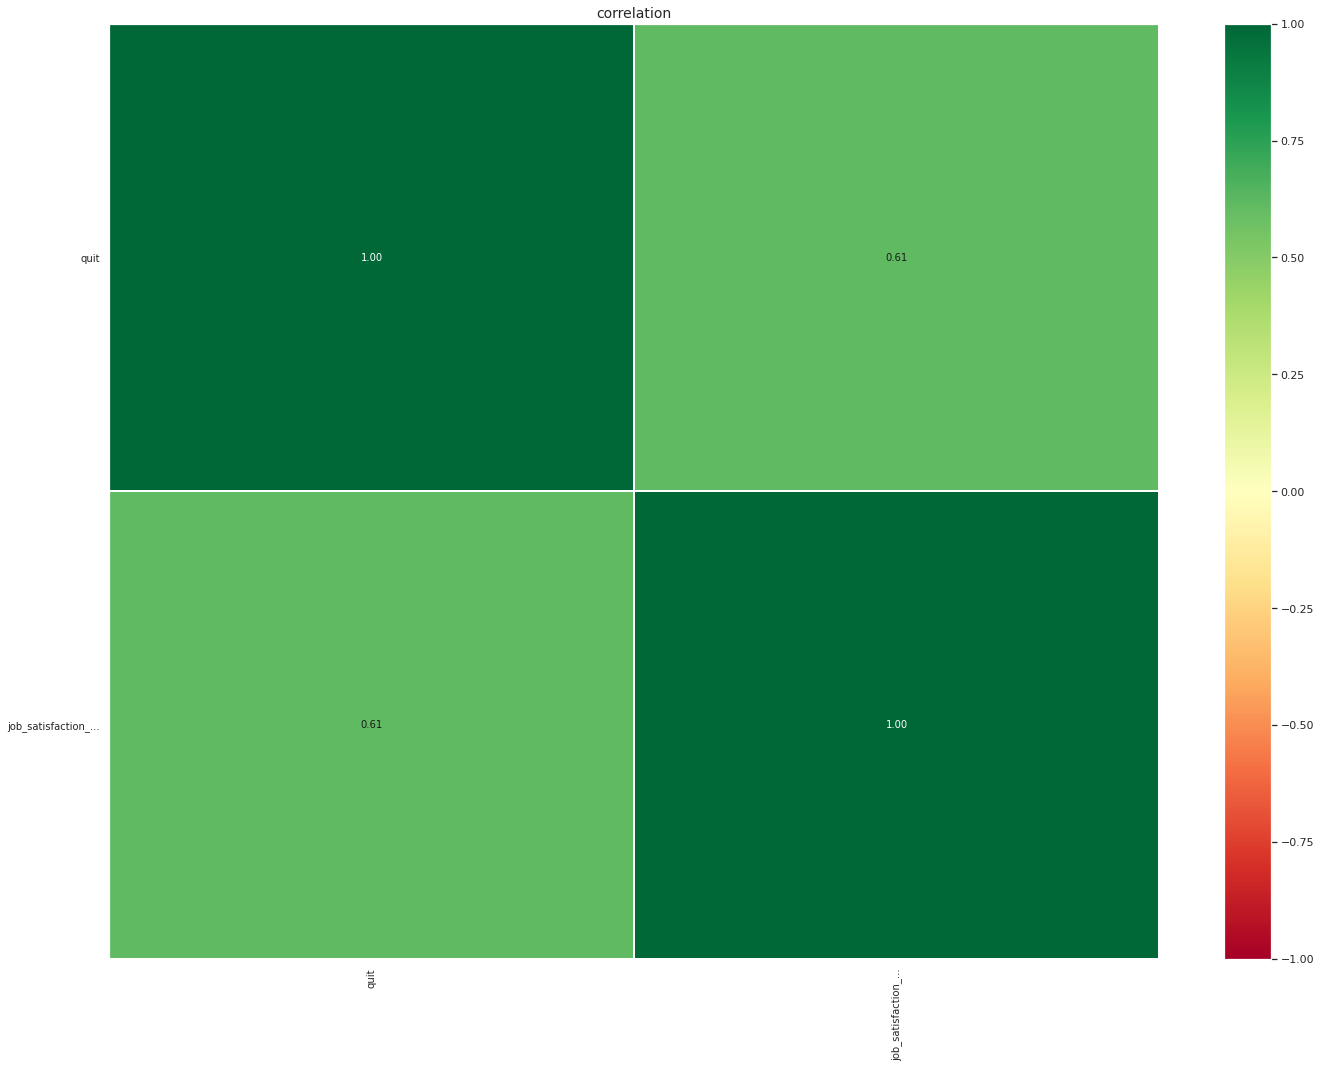

In [96]:
phik_overview = target_features.drop('id', axis=1).phik_matrix(interval_cols=interval_col)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        figsize=(20, 15))

**Состовление портреа ушедшего работника:**

Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

In [97]:
df_train_quit[df_train_quit['quit']=='no']['salary'].mean()

37702.22841225627

In [98]:
df_train_quit[df_train_quit['quit']=='yes']['salary'].mean()

23885.106382978724

Средняя зарплата уходящих меньше в среднем на ~15к - логично

In [99]:
df_train_quit.groupby(['level'])['quit'].value_counts(normalize=True)

level   quit
junior  yes     0.514623
        no      0.485377
middle  no      0.936246
        yes     0.063754
sinior  no      0.952381
        yes     0.047619
Name: quit, dtype: float64

In [100]:
df_train_quit.groupby(['dept'])['quit'].value_counts(normalize=True)

dept        quit
hr          no      0.750000
            yes     0.250000
marketing   no      0.719931
            yes     0.280069
purchasing  no      0.717687
            yes     0.282313
sales       no      0.716968
            yes     0.283032
technology  no      0.702586
            yes     0.297414
Name: quit, dtype: float64

In [101]:
df_train_quit.groupby(['workload'])['quit'].value_counts(normalize=True)

workload  quit
high      no      0.820475
          yes     0.179525
low       no      0.570364
          yes     0.429636
medium    no      0.769594
          yes     0.230406
Name: quit, dtype: float64

In [102]:
df_train_quit.groupby(['employment_years'])['quit'].value_counts(normalize=True)

employment_years  quit
1                 yes     0.608122
                  no      0.391878
2                 no      0.626770
                  yes     0.373230
3                 no      0.659708
                  yes     0.340292
4                 no      0.931298
                  yes     0.068702
5                 no      0.936464
                  yes     0.063536
6                 no      0.966216
                  yes     0.033784
7                 no      0.977273
                  yes     0.022727
8                 no      0.982759
                  yes     0.017241
9                 no      0.977941
                  yes     0.022059
10                no      0.966667
                  yes     0.033333
Name: quit, dtype: float64

In [103]:
df_train_quit.groupby(['last_year_promo'])['quit'].value_counts(normalize=True)

last_year_promo  quit
no               no      0.710059
                 yes     0.289941
yes              no      0.991150
                 yes     0.008850
Name: quit, dtype: float64

In [104]:
df_train_quit.groupby(['supervisor_evaluation'])['quit'].value_counts(normalize=True)

supervisor_evaluation  quit
1                      no      0.529703
                       yes     0.470297
2                      no      0.580563
                       yes     0.419437
3                      no      0.575831
                       yes     0.424169
4                      no      0.827086
                       yes     0.172914
5                      no      0.884615
                       yes     0.115385
Name: quit, dtype: float64

In [105]:
df_train_quit.groupby(['last_year_violations'])['quit'].value_counts(normalize=True)

last_year_violations  quit
no                    no      0.739508
                      yes     0.260492
yes                   no      0.581651
                      yes     0.418349
Name: quit, dtype: float64

Средняя зарплата уходящих меньше в среднем на ~15к
Чаще уходят:
- джуны
- люди из отдела technology
- у которых не было повышения за год
- стаж которых год или меньше
- с низкой нагрузкой
- нарушившие условия тд

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

Уволившиеся сотрудники и оставшиеся:

In [106]:
quit = target_features[target_features['quit'] == 'yes']
stayed = target_features[target_features['quit'] == 'no']

/tmp/ipykernel_233/4078101486.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(quit['job_satisfaction_rate'], shade=True, color="red", label="quit", alpha=.7)
/tmp/ipykernel_233/4078101486.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(stayed['job_satisfaction_rate'], shade=True, color="green", label="stayed", alpha=.7)


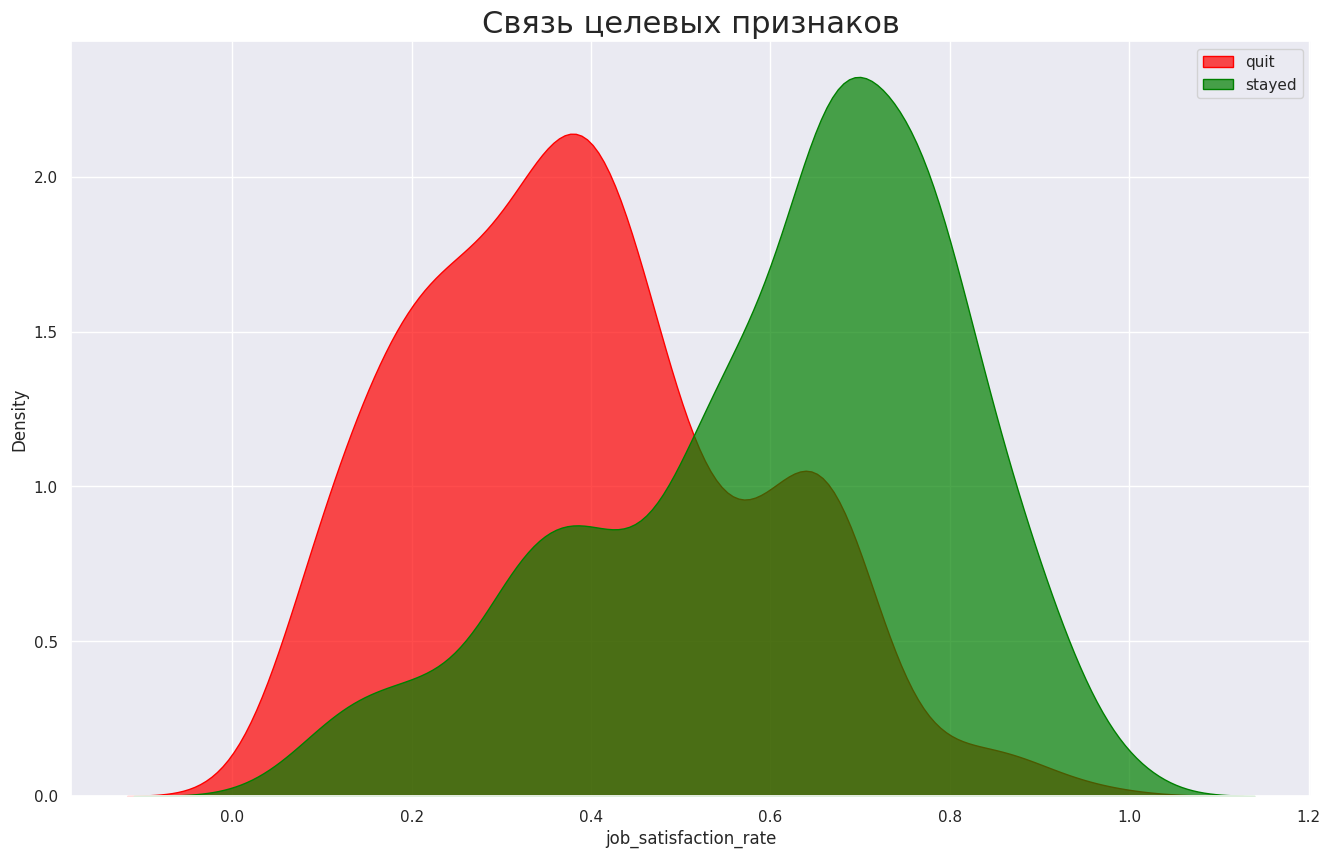

In [107]:
df = target_features

plt.figure(figsize=(16,10), dpi= 100)
sns.kdeplot(quit['job_satisfaction_rate'], shade=True, color="red", label="quit", alpha=.7)
sns.kdeplot(stayed['job_satisfaction_rate'], shade=True, color="green", label="stayed", alpha=.7)

plt.title('Связь целевых признаков', fontsize=22)
plt.legend()
plt.show()

job_satisfaction_rate для ушедших и оставшихся сотрудников

Ушедшие работники имеют более низкий job_satisfaction_rate нежели оставшиеся работники:

- ушедшие в среднем имеют 0.37 job_satisfaction_rate
- оставшиеся - 0.75

**Шаг 5. Подготовка данных**

Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

Разделение на входные и целевой признаки:

In [108]:
df_train_quit = df_train_quit.drop('id', axis=1)

In [109]:
df_train_quit.duplicated().sum()

1413

In [110]:
df_train_quit = df_train_quit.drop_duplicates()
df_train_quit.duplicated().sum()

0

In [111]:
X_classification_train = df_train_quit.drop('quit', axis=1)

In [112]:
X_train_classification = pd.DataFrame(
    data_preprocessor.fit_transform(X_classification_train),
    columns=data_preprocessor.get_feature_names_out())
X_train_classification.head()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,-0.851101,0.585172,1.038618
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.851101,0.585172,-0.584578
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.302478,-2.192517,0.005676
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.851101,-0.340724,-0.805922
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.851101,1.511068,-0.732141


In [113]:
y_classification_train = df_train_quit['quit']

In [114]:
target_test_quit = df_test_target_quit.merge(df_test_features['id'], how='right', on='id')
target_test_quit.head()

,id,quit
0,485046,no
1,686555,no
2,467458,no
3,418655,no
4,789145,no


In [115]:
df_test_features = df_test_features.merge(df_test_target_quit, on='id')
df_test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


In [116]:
y_classification_test = df_test_features['quit']
y_classification_test.head()

0    no
1    no
2    no
3    no
4    no
Name: quit, dtype: object

Целевой признак тестовой выборки:

In [117]:
X_classification_test = df_test_features.drop(['quit'], axis=1)

Кодировка строковых классов числами:

In [118]:
label_encoder = LabelEncoder()

y_classification_train = label_encoder.fit_transform(y_classification_train)
y_classification_test = label_encoder.transform(y_classification_test)

Добавление job_satisfaction_rate, предсказанной лучшей моделью

In [119]:
#предсказание
prediction = rs.predict(X_train_classification)

In [120]:
prediction1 = rs.predict(X_test_p)

In [121]:
#добавление
X_train_classification['job_satisfaction_rate'] = prediction

In [122]:
X_train_classification

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,job_satisfaction_rate
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,-0.851101,0.585172,1.038618,0.517143
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.851101,0.585172,-0.584578,0.841000
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.302478,-2.192517,0.005676,0.351111
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-0.851101,-0.340724,-0.805922,0.180000
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.851101,1.511068,-0.732141,0.670769
...,...,...,...,...,...,...,...,...,...,...,...,...
2582,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.851101,0.585172,-0.879704,0.840000
2583,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.235627,1.511068,-1.174831,0.785556
2584,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-1.235627,0.585172,0.300802,0.514167
2585,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.851101,0.585172,-1.543739,0.544286


In [123]:
#добавление
X_test_p['job_satisfaction_rate'] = prediction1
X_test_p.head()

,ohe__dept_marketing,ohe__dept_purchasing,ohe__dept_sales,ohe__dept_technology,ohe__last_year_promo_yes,ohe__last_year_violations_yes,ord__level,ord__workload,num__employment_years,num__supervisor_evaluation,num__salary,job_satisfaction_rate
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.710671,1.497231,-0.375942,0.845714
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.101784,0.522694,-0.296201,0.676667
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.462670,0.522694,-1.013873,0.683750
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.853784,0.522694,-1.013873,0.686250
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.462670,1.497231,0.421472,0.839286


**Шаг 6. Обучение модели**

**LogisticRegression**

In [124]:
model_logistic_regression = LogisticRegression(random_state=RANDOM_STATE)

parameters = {
     'C': np.arange(0.1, 2, 0.05)}


rs_log_reg = RandomizedSearchCV(
    model_logistic_regression,
    parameters,
    n_jobs = -1,
    scoring ='roc_auc',
    random_state=RANDOM_STATE,
    refit=True
)

rs_log_reg.fit(X_train_classification, y_classification_train)

RandomizedSearchCV(estimator=LogisticRegression(random_state=42), n_jobs=-1,
                   param_distributions={'C': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 ,
       1.75, 1.8 , 1.85, 1.9 , 1.95])},
                   random_state=42, scoring='roc_auc')

In [125]:
print('ROC AUC:', round(rs_log_reg.best_score_, 3))
print('Модель и её параметры:\n\n', rs_log_reg.best_estimator_)

ROC AUC: 0.902
Модель и её параметры:

 LogisticRegression(C=1.3000000000000005, random_state=42)


**DecisionTreeClassifier**

In [126]:
model_decision_tree_classifier = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters = {
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 11),
    'max_depth': range(2, 11)
}

rs = RandomizedSearchCV(
    model_decision_tree_classifier,
    parameters,
    n_jobs = -1,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE,
    refit=True

)

rs.fit(X_train_classification, y_classification_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'max_depth': range(2, 11),
                                        'min_samples_leaf': range(1, 11),
                                        'min_samples_split': range(2, 11)},
                   random_state=42, scoring='roc_auc')

In [127]:
print('ROC AUC:', round(rs.best_score_, 3))
print('Модель и её параметры:\n\n', rs.best_estimator_)

ROC AUC: 0.902
Модель и её параметры:

 DecisionTreeClassifier(max_depth=4, min_samples_leaf=6, min_samples_split=4,
                       random_state=42)


<div class="alert alert-info">
<h2> Создал модель SVC<a class="tocSkip"> </h2>

In [128]:
model_SVC = SVC(random_state=RANDOM_STATE, probability=True)


parameters = {'C': np.arange(0.1, 2, 0.1)}

rs_svc = RandomizedSearchCV(
    model_SVC,
    parameters,
    n_jobs = -1,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE)


rs_svc.fit(X_train_classification, y_classification_train)

RandomizedSearchCV(estimator=SVC(probability=True, random_state=42), n_jobs=-1,
                   param_distributions={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])},
                   random_state=42, scoring='roc_auc')

In [129]:
print('ROC AUC:', round(rs_svc.best_score_, 3))
print('Модель и её параметры:\n\n', rs_svc.best_estimator_)

ROC AUC: 0.897
Модель и её параметры:

 SVC(C=0.4, probability=True, random_state=42)


ROC-AUC на тестовой выборке:

Критерий успеха: ROC-AUC ≥ 0.91

In [130]:
prediction = rs.predict_proba(X_test_p)[:, 1]
roc_auc_score(y_classification_test, prediction)

0.910270229558071

**Использованные модели: SVC, DecisionTreeClassifier, LogisticRegression**

Лучшая модель и её параметры:

 DecisionTreeClassifier(max_depth=4, min_samples_leaf=6, min_samples_split=4,
                       random_state=42)

**ROC-AUC на тестовой выборке = 0.910270229558071**

**Общий вывод:**
- были загружены и ислеедованны датафреймы: выявлены пропуски, выведены значения признаков
- исследованы целевыеп признаки
- написаны функции для построения гистограм и барплотов и сделаны соответствующие выводы по ним
- созданы матрицы корреляции и тепловые карты
- описан портрет «уволившегося сотрудника»
- Связь целевых признаков: визуализировал и сравнил распределения признака job_satisfaction_rate, используя данные с обоими целевыми признаками тестовой выборки.
- добавил job_satisfaction_rate, предсказанный лучшей моделью первой задачи
- выполнена подготовка данных к МО

- **Критерий успеха первой задачи: SMAPE ≤ 15 на тестовой выборке.**

Результат - 14.49

- **Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке.**

Результат - 0.91




**Рекомендации по сокращению уровня увольнения среди сотрудников:**

Во-первых надо понимать, что имеется связь между двумя целевыми признакми: *job_satisfaction_rate* и *quit*


Ушедшие работники имеют более низкий job_satisfaction_rate нежели оставшиеся работники:

- ушедшие в среднем имеют 0.37 job_satisfaction_rate
- оставшиеся - 0.75

А от чего зависит *job_satisfaction_rate*?

**Целевой признак *job_satisfaction_rate* имеет сильную зависимость с *supervisor_evaluation* и *last_year_violations*** (оценка качества работы сотрудника, которую дал руководитель и показатель, нарушал ли сотрудник трудовой договор за последний год)

Также сильную зависимость с уходом сотрудника имеют следующие признаки: зарплата сотрудника, его уровень и его стаж работы

Средняя зарплата уходящих меньше в среднем на ~15к
Чаще уходят:
- джуны
- люди из отдела technology
- у которых не было повышения за год
- стаж которых год или меньше
- с низкой нагрузкой
- нарушившие условия тд


**Какую базовую рекомдацию можно дать, чтобы удержать сотрудника:**
- поднимать сотрудников в уровне (например с джуна до мидла)
- своевременно поднимать зарплаты
- повышать нагрузку на сотрудника
- постараться помочь сотруднику не нарушать тд))
- и самое главное постараться увеличить показатель job_satisfaction_rate


